Sam Bieler, Max Benegas, Andrew Puopolo, Kate Schember

In [1]:
import pandas as pd
import numpy as np
import math
import requests
from bs4 import BeautifulSoup
from bs4 import Comment
from time import sleep
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import KFold
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
kf = KFold(n_splits=5)
pd.set_option('display.max_columns', None)

//anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def bin_accuracy(n_bins, preds, actual_outcomes):
    bin_size = int(100/n_bins)
    bins = list(range(0,100,bin_size))
    for i in range(len(bins)):
        bins[i] += bin_size/2.
    bin_win_pct = []
    correct_win_pct = []
    for i in range(0,100,bin_size):
        pct = float(i)/100
        in_bin = [pred > pct and pred <= (pct + bin_size/100.) for pred in preds]
        num_in_bin = np.sum(in_bin)
        wins_in_bin = in_bin * actual_outcomes
        num_correct = np.sum(wins_in_bin)
        if num_in_bin != 0:
            bin_win_pct.append(float(num_correct)/num_in_bin)
            correct_win_pct.append(pct + bin_size/200.)
    #plt.bar(bins,bin_win_pct,width = bin_size)
    #plt.show()
    return metrics.r2_score(correct_win_pct,bin_win_pct)

def bin_accuracy_plot(n_bins, preds, actual_outcomes):
    bin_size = int(100/n_bins)
    bins = list(range(0,100,bin_size))
    for i in range(len(bins)):
        bins[i] += bin_size/2.
    bin_win_pct = []
    correct_win_pct = []
    for i in range(0,100,bin_size):
        pct = float(i)/100
        in_bin = [pred > pct and pred < (pct + bin_size/100.) for pred in preds]
        num_in_bin = np.sum(in_bin)
        wins_in_bin = in_bin * actual_outcomes
        num_correct = np.sum(wins_in_bin)
        bin_win_pct.append(float(num_correct)/num_in_bin)
        correct_win_pct.append(pct + bin_size/200.)
    print(bin_win_pct)
    plt.bar(bins,bin_win_pct,width = bin_size)
    plt.show()
    return metrics.r2_score(correct_win_pct,bin_win_pct)

In [3]:
plays = pd.read_csv('MLBPlayDataFinal.csv').drop('Unnamed: 0', axis=1)

In [4]:
plays.columns = ['gameID', 'date', 'stadium', 'attendance', 'inning', 'starting_pitcher', 
                 'is_starting_pitcher', 'is_away', 'batting_position', 'score', 'num_outs',
                 'runners_on_base', 'pitch_details', 'run_out_result', 'team_at_bat', 
                 'batter', 'pitcher', 'WEC%', 'wWE%', 'play_description', 'team_won']

In [5]:
plays_raw = plays.copy()

In [6]:
plays["is_single"] = ['Single' in play for play in plays['play_description']]
plays["is_double"] = ['Double' in play for play in plays['play_description']]
plays["is_triple"] = ['Triple' in play for play in plays['play_description']]
plays["is_homerun"] = ['Home Run' in play for play in plays['play_description']]
plays["is_strikeout"] = ['Strikeout' in play for play in plays['play_description']]
plays["is_groundout"] = ['Groundout' in play for play in plays['play_description']]
plays["is_walk"] = ['Walk' in play for play in plays['play_description']]
plays["is_steal"] = [('Steal' or 'Steals' or 'steal' or 'steals') in play for play in plays['play_description']]

In [7]:
plays['runner_on_first']= [0 if runner[0]=='-' else 1 for runner in plays['runners_on_base']]
plays['runner_on_second']= [0 if runner[1]=='-' else 1 for runner in plays['runners_on_base']]
plays['runner_on_third']= [0 if runner[2]=='-' else 1 for runner in plays['runners_on_base']]

In [8]:
plays['runs_in_atbat'] = [0 if type(row)==float else row.count('R') for row in plays['run_out_result']]
plays['outs_in_atbat'] = [0 if type(row)==float else row.count('O') for row in plays['run_out_result']]

In [9]:
plays['batting_team_runs'] = [score.split('-')[0] for score in plays['score']]
plays['fielding_team_runs'] = [score.split('-')[1] for score in plays['score']]

In [10]:
plays["pitch_count"] = [pitch.split(',')[0] if isinstance(pitch,str) else None for pitch in plays['pitch_details']]
plays["ball_count"] = [pitch.split('(')[1].split('-')[0] if isinstance(pitch,str) else None for pitch in plays['pitch_details']]
plays["strike_count"] = [pitch.split('(')[1].split('-')[1].split(')')[0] if isinstance(pitch,str) else None for pitch in plays['pitch_details']]

In [11]:
plays['date'] = pd.to_datetime(plays['date'])

In [12]:
plays['home_team_won'] = np.where(plays['team_won'] == plays['is_away'], 0, 1)

In [38]:
# plays['wWE%'] = plays['wWE%'].apply(lambda x: int(x.replace('%','')))
# plays['WEC%'] = plays['WEC%'].apply(lambda x: int(x.replace('%','')))

In [13]:
plays.head()

,gameID,date,stadium,attendance,inning,starting_pitcher,is_starting_pitcher,is_away,batting_position,score,num_outs,runners_on_base,pitch_details,run_out_result,team_at_bat,batter,pitcher,WEC%,wWE%,play_description,team_won,is_single,is_double,is_triple,is_homerun,is_strikeout,is_groundout,is_walk,is_steal,runner_on_first,runner_on_second,runner_on_third,runs_in_atbat,outs_in_atbat,batting_team_runs,fielding_team_runs,pitch_count,ball_count,strike_count,home_team_won
0,1,2006-09-08,Angel Stadium of Anaheim,"42,259",1,Joe Saunders,1,1,1,0-0,0,---,"5,(1-2) CFBFX",NaN,TOR,Reed Johnson,Joe Saunders,-6%,44%,Double to CF (Fly Ball to Deep CF),0,False,True,False,False,False,False,False,False,0,0,0,0,0,0,0,5,1,2,1
1,1,2006-09-08,Angel Stadium of Anaheim,"42,259",1,Joe Saunders,1,1,2,0-0,0,-2-,"6,(3-2) FBFBBX",O,TOR,Aaron Hill,Joe Saunders,4%,48%,Lineout: 3B,0,False,False,False,False,False,False,False,False,0,1,0,0,1,0,0,6,3,2,1
2,1,2006-09-08,Angel Stadium of Anaheim,"42,259",1,Joe Saunders,1,1,3,0-0,1,-2-,"2,(1-0) *BX",RO,TOR,Vernon Wells,Joe Saunders,-4%,44%,Single to RF (Line Drive); Johnson Scores; out...,0,True,False,False,False,False,False,False,False,0,1,0,1,1,0,0,2,1,0,1
3,1,2006-09-08,Angel Stadium of Anaheim,"42,259",1,Joe Saunders,1,1,4,1-0,2,---,"2,(0-1) CX",O,TOR,Troy Glaus,Joe Saunders,1%,45%,Lineout: 3B-1B,0,False,False,False,False,False,False,False,False,0,0,0,0,1,1,0,2,0,1,1
4,1,2006-09-08,Angel Stadium of Anaheim,"42,259",1,A.J. Burnett,1,0,1,0-1,0,---,"4,(1-2) BCCX",NaN,LAA,Maicer Izturis,A.J. Burnett,4%,49%,Single to 1B (Ground Ball),1,True,False,False,False,False,False,False,False,0,0,0,0,0,0,1,4,1,2,1


In [14]:
plays_first_play = plays.drop_duplicates(subset='gameID', keep='first')
plays_last_play = plays.drop_duplicates(subset='gameID', keep='last')

In [15]:
plays_last_play

,gameID,date,stadium,attendance,inning,starting_pitcher,is_starting_pitcher,is_away,batting_position,score,num_outs,runners_on_base,pitch_details,run_out_result,team_at_bat,batter,pitcher,WEC%,wWE%,play_description,team_won,is_single,is_double,is_triple,is_homerun,is_strikeout,is_groundout,is_walk,is_steal,runner_on_first,runner_on_second,runner_on_third,runs_in_atbat,outs_in_atbat,batting_team_runs,fielding_team_runs,pitch_count,ball_count,strike_count,home_team_won
63,1,2006-09-08,Angel Stadium of Anaheim,"42,259",9,Joe Saunders,0,1,4,1-4,2,---,"4,(2-1) CBBX",O,TOR,Troy Glaus,Francisco Rodriguez,0%,100%,Popfly: 1B,0,False,False,False,False,False,False,False,False,0,0,0,0,1,1,4,4,2,1,1
141,2,2006-09-08,Chase Field,"25,299",9,Livan Hernandez,0,1,6,1-13,2,---,"1,(0-0) X",O,STL,Mike Rose,Randy Choate,0%,100%,Lineout: 1B,0,False,False,False,False,False,False,False,False,0,0,0,0,1,1,13,1,0,0,1
217,3,2006-09-08,Turner Field,"30,977",9,Tim Hudson,0,1,9,4-8,2,---,"3,(0-2) .CCX",O,CHC,Freddie Bynum,Bob Wickman,0%,100%,Groundout: 2B-1B,0,False,False,False,False,False,True,False,False,0,0,0,0,1,4,8,3,0,2,1
292,4,2006-09-08,Oriole Park at Camden Yards,"36,214",9,Erik Bedard,0,1,1,4-9,2,1--,"1,(0-0) .X",O,NYY,Kevin Thompson,Julio Manon,0%,100%,Lineout: LF,0,False,False,False,False,False,False,False,False,1,0,0,0,1,4,9,1,0,0,1
383,5,2006-09-08,Fenway Park,"36,531",9,Odalis Perez,0,0,9,9-10,2,---,"6,(3-2) .BBCBFX",O,BOS,Trot Nixon,Joe Nelson,5%,100%,Flyball: RF,0,False,False,False,False,False,False,False,False,0,0,0,0,1,9,10,6,3,2,0
473,6,2006-09-08,U.S. Cellular Field,"37,188",9,Paul Byrd,0,0,1,5-6,0,1--,"4,(0-2) .MSFX",RR,CHW,A.J. Pierzynski,Tom Mastny,64%,100%,Home Run (Fly Ball); Iguchi Scores,1,False,False,False,True,False,False,False,False,1,0,0,2,0,5,6,4,0,2,1
554,7,2006-09-08,Great American Ball Park,"17,631",9,Kyle Lohse,0,1,1,1-9,2,12-,"2,(1-0) .BX",O,PIT,Rajai Davis,Gary Majewski,0%,100%,Groundout: 2B-1B,0,False,False,False,False,False,True,False,False,1,1,0,0,1,1,9,2,1,0,1
644,8,2006-09-08,Coors Field,"22,214",9,Byung-Hyun Kim,0,1,8,8-11,2,-23,"2,(0-1) CX",O,WSN,Jose Vidro,Brian Fuentes,5%,100%,Groundout: 2B-1B,0,False,False,False,False,False,True,False,False,0,1,1,0,1,8,11,2,0,1,1
714,9,2006-09-08,Dolphins Stadium,"21,432",9,Jamie Moyer,0,0,6,2-3,2,---,"4,(1-2) CBCS",O,FLA,Joe Borchard,Tom Gordon,5%,100%,Strikeout Swinging,0,False,False,False,False,True,False,False,False,0,0,0,0,1,2,3,4,1,2,0
787,10,2006-09-08,Miller Park,"19,677",9,Roy Oswalt,0,0,7,3-4,2,1--,"5,(2-2) .SBCBS",O,MIL,Gabe Gross,Brad Lidge,10%,100%,Strikeout Swinging,0,False,False,False,False,True,False,False,False,1,0,0,0,1,3,4,5,2,2,0


In [16]:
np.random.seed(9001)
msk = np.random.rand(len(plays)) < 0.75
plays_train = plays[msk]
plays_test = plays[~msk]

In [17]:
plays_train = plays_train.drop(['stadium', 'starting_pitcher', 'score', 
                                'runners_on_base', 'pitch_details',
                                'play_description', 'run_out_result'],axis=1)
plays_test = plays_test.drop(['stadium', 'starting_pitcher', 'score', 
                              'runners_on_base', 'pitch_details', 
                              'play_description', 'run_out_result'],axis=1)
plays_all = plays.drop(['stadium', 'starting_pitcher', 'score', 
                              'runners_on_base', 'pitch_details', 
                              'play_description', 'run_out_result'],axis=1)

In [18]:
plays_train['attendance'] = plays_train['attendance'].apply(lambda x: int(x.replace(',','')) if type(x)==str else 0)
plays_test['attendance'] = plays_test['attendance'].apply(lambda x: int(x.replace(',','')) if type(x)==str else 0)
plays_all['attendance'] = plays_all['attendance'].apply(lambda x: int(x.replace(',','')) if type(x)==str else 0)


for col in ['batting_team_runs', 'fielding_team_runs', 'pitch_count', 'strike_count', 'ball_count']:
    plays_train[col] = plays_train[col].apply(lambda x: int(float(x)) if type(x)==str and len(x) > 0 else -1)
    plays_test[col] = plays_test[col].apply(lambda x: int(float(x)) if type(x)==str and len(x) > 0 else -1)
    plays_all[col] = plays_all[col].apply(lambda x: int(float(x)) if type(x)==str and len(x) > 0 else -1)

plays_train['run_diff'] = plays_train['batting_team_runs'] - plays_train['fielding_team_runs']
plays_test['run_diff'] = plays_test['batting_team_runs'] - plays_test['fielding_team_runs']
plays_all['run_diff'] = plays_all['batting_team_runs'] - plays_all['fielding_team_runs']

plays_train['run_scored'] = plays_train['batting_team_runs'] + plays_train['fielding_team_runs']
plays_test['run_scored'] = plays_test['batting_team_runs'] + plays_test['fielding_team_runs']
plays_all['run_scored'] = plays_all['batting_team_runs'] + plays_all['fielding_team_runs']

for col in ['is_single', 'is_double', 'is_triple', 'is_homerun', 'is_strikeout', 'is_groundout',
            'is_walk', 'is_steal']:
    plays_train[col] = plays_train[col].astype(int)
    plays_test[col] = plays_test[col].astype(int)
    plays_all[col] = plays_all[col].astype(int)

In [19]:
plays_train.columns

Index([u'gameID', u'date', u'attendance', u'inning', u'is_starting_pitcher',
       u'is_away', u'batting_position', u'num_outs', u'team_at_bat', u'batter',
       u'pitcher', u'WEC%', u'wWE%', u'team_won', u'is_single', u'is_double',
       u'is_triple', u'is_homerun', u'is_strikeout', u'is_groundout',
       u'is_walk', u'is_steal', u'runner_on_first', u'runner_on_second',
       u'runner_on_third', u'runs_in_atbat', u'outs_in_atbat',
       u'batting_team_runs', u'fielding_team_runs', u'pitch_count',
       u'ball_count', u'strike_count', u'home_team_won', u'run_diff',
       u'run_scored'],
      dtype='object')

In [20]:
X_train = plays_train.drop(['gameID', 'home_team_won', 'team_won', 'WEC%', 'wWE%', 'team_at_bat', 'batter', 'pitcher', 'date', 'pitch_count'], axis=1).values
X_test = plays_test.drop(['gameID', 'home_team_won', 'team_won', 'WEC%', 'wWE%', 'team_at_bat', 'batter', 'pitcher', 'date', 'pitch_count'], axis=1).values
X_all = plays_all.drop(['gameID', 'home_team_won', 'team_won', 'WEC%', 'wWE%', 'team_at_bat', 'batter', 'pitcher', 'date', 'pitch_count'], axis=1).values
y_train = plays_train['team_won'].values
y_test = plays_test['team_won'].values
y_all = plays_all['team_won'].values

In [21]:
plays_train.head()

,gameID,date,attendance,inning,is_starting_pitcher,is_away,batting_position,num_outs,team_at_bat,batter,pitcher,WEC%,wWE%,team_won,is_single,is_double,is_triple,is_homerun,is_strikeout,is_groundout,is_walk,is_steal,runner_on_first,runner_on_second,runner_on_third,runs_in_atbat,outs_in_atbat,batting_team_runs,fielding_team_runs,pitch_count,ball_count,strike_count,home_team_won,run_diff,run_scored
0,1,2006-09-08,42259,1,1,1,1,0,TOR,Reed Johnson,Joe Saunders,-6%,44%,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,5,1,2,1,0,0
3,1,2006-09-08,42259,1,1,1,4,2,TOR,Troy Glaus,Joe Saunders,1%,45%,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,2,0,1,1,1,1
5,1,2006-09-08,42259,1,1,0,2,0,LAA,Orlando Cabrera,A.J. Burnett,6%,55%,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,4,1,2,1,-1,1
6,1,2006-09-08,42259,1,1,0,3,0,LAA,Vladimir Guerrero,A.J. Burnett,-11%,44%,1,0,1,0,0,0,0,0,0,1,1,0,0,2,0,1,1,0,0,1,-1,1
9,1,2006-09-08,42259,2,1,1,6,1,TOR,Alex Rios,Joe Saunders,-4%,39%,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,5,2,2,1,1,1


In [22]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((911767, 25), (911767,), (303722, 25), (303722,))

array([[42259,     1,     1,     1,     1,     0,     0,     1,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     1,     2,     0],
       [42259,     1,     1,     1,     4,     2,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            1,     1,     0,     0,     1,     1],
       [42259,     1,     1,     0,     2,     0,     1,     0,     0,
            0,     0,     0,     0,     0,     1,     0,     0,     0,
            0,     0,     1,     1,     2,    -1],
       [42259,     1,     1,     0,     3,     0,     0,     1,     0,
            0,     0,     0,     0,     0,     1,     1,     0,     0,
            2,     0,     1,     0,     0,    -1],
       [42259,     2,     1,     1,     6,     1,     0,     1,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     1,     0,     2,     2,     1]])

In [ ]:
cross_val_scores = []
trees = [2**x for x in range(7)]
for md in [1,2,5,10,None]:
    for tree in trees:
        rf = RandomForest(max_depth = md, n_estimators=tree, max_features='sqrt')
        cv_scores = []
        for train_index, val_index in kf.split(X_train):
            rf.fit(X_train[train_index],y_train[train_index])
            preds = rf.predict_proba(X_train[val_index])
            acc = bin_accuracy(20, [pred[1] for pred in preds], y_train[val_index])
            cv_scores.append(acc)
        cv_score = cross_val_score(rf, X_train, y_train, cv = 5)
        cross_val_scores.append((np.mean(cv_scores), np.mean(cv_score), tree, md))
cross_val_scores

In [25]:
cross_val_scores

[(0.96061655730839846, 0.6121960523646961, 1, 1),
 (-0.038708496427417735, 0.66546263158118868, 2, 1),
 (-6.9581184404845375, 0.67162677470141907, 4, 1),
 (-8.0534078621678375, 0.67588437461581041, 8, 1),
 (-5.0917468011981715, 0.72983996565301645, 16, 1),
 (-7.5692897182713255, 0.73591170498030878, 32, 1),
 (-6.0986512145642813, 0.73595118929564163, 64, 1),
 (0.97770333666329612, 0.6517983941675336, 1, 2),
 (0.15779616465215865, 0.70203570427140816, 2, 2),
 (0.47176812015138447, 0.69891204695430775, 4, 2),
 (-0.25147859856588317, 0.73397590098155696, 8, 2),
 (-0.40382482680612125, 0.73443983513692968, 16, 2),
 (-0.31959911185759771, 0.73659170402718521, 32, 2),
 (-0.71344437866576593, 0.73599615717944844, 64, 2),
 (0.99047796778192954, 0.7133335970239757, 1, 5),
 (0.94129184613409789, 0.72784493994474797, 2, 5),
 (0.96106829964907559, 0.74057517026575215, 4, 5),
 (0.93726053545361343, 0.74504342893382458, 8, 5),
 (0.93110279964820231, 0.74494142538208674, 16, 5),
 (0.92674230710251104

[0.01129083079508455, 0.046372221908047274, 0.10073215866119559, 0.15485196600354909, 0.21155042203465127, 0.2764505119453925, 0.33976992604765816, 0.3788206654043819, 0.4231329475217511, 0.45886499823757493, 0.5236622332199196, 0.5732673267326732, 0.6386511593884866, 0.6786138794916339, 0.7321138558851183, 0.7871124334481678, 0.8389022214017599, 0.9009514682729824, 0.9533066030553723, 0.9845033112582782]


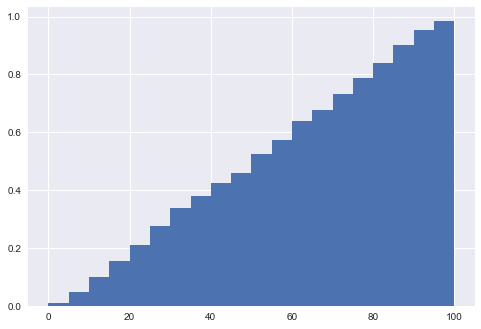

0.99708765046293724

In [26]:
rf = RandomForest(max_depth = 10, n_estimators=10, max_features='sqrt')
rf.fit(X_train,y_train)
rf_test_preds = rf.predict_proba(X_test)
bin_accuracy_plot(20,[pred[1] for pred in rf_test_preds],y_test)

In [28]:
Cs = [10**x for x in range(6)]
cross_val_scores = []
for c in Cs:
    logit = LogisticRegression(C = c)
    cv_scores = []
    for train_index, val_index in kf.split(X_train):
        logit.fit(X_train[train_index],y_train[train_index])
        preds = logit.predict_proba(X_train[val_index])
        acc = bin_accuracy(20, [pred[1] for pred in preds], y_train[val_index])
        cv_scores.append(acc)
    cv_score = cross_val_score(logit, X_train, y_train, cv = 5)
    cross_val_scores.append((np.mean(cv_scores), np.mean(cv_score), c))
cross_val_scores

[(0.99626202161949207, 0.75323959280912378, 1),
 (0.99626114967646784, 0.75324068958296353, 10),
 (0.99626112668802658, 0.75324068958296353, 100),
 (0.99626133116740445, 0.75324068958296353, 1000),
 (0.99626076436317257, 0.75324068958296353, 10000),
 (0.99626094308400148, 0.75324068958296353, 100000)]

[0.01835387323943662, 0.07165783384339777, 0.11793080505655355, 0.16442074648570043, 0.2113143343258188, 0.25096907959974757, 0.317940260216236, 0.37773462043753925, 0.42574767076748854, 0.48366083445491254, 0.5401867209096125, 0.5834384195039932, 0.6376655684797956, 0.6983086509670632, 0.7433012583271651, 0.780558789289872, 0.822808671065033, 0.8772222222222222, 0.9167494536061991, 0.9689342495832147]


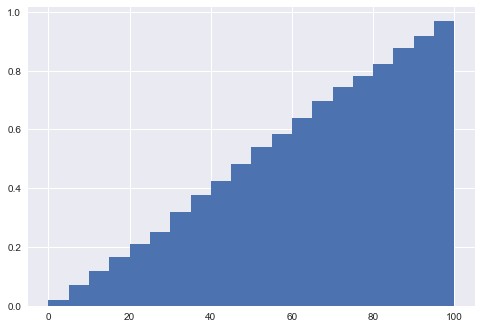

0.99843554923254307

In [29]:
logit = LogisticRegression(C = 10000)
logit.fit(X_train, y_train)
logit_test_preds = logit.predict_proba(X_test)
bin_accuracy_plot(20,[pred[1] for pred in logit_test_preds],y_test)

In [30]:
logit_test_preds

array([[ 0.52902562,  0.47097438],
       [ 0.4498386 ,  0.5501614 ],
       [ 0.55293497,  0.44706503],
       ..., 
       [ 0.3429999 ,  0.6570001 ],
       [ 0.0392451 ,  0.9607549 ],
       [ 0.96383187,  0.03616813]])

In [31]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

lda_train_preds = lda.predict_proba(X_train)
lda_test_preds = lda.predict_proba(X_test)

//anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [32]:
lda.predict_proba(X_test)

array([[ 0.50703028,  0.49296972],
       [ 0.45687798,  0.54312202],
       [ 0.51034247,  0.48965753],
       ..., 
       [ 0.38462568,  0.61537432],
       [ 0.10078737,  0.89921263],
       [ 0.92343455,  0.07656545]])

[0.004123144584936778, 0.030421714181619455, 0.06508931965032307, 0.09516279069767442, 0.14243708380178155, 0.195639932426997, 0.24950711938663747, 0.3352858481724461, 0.4021776259607173, 0.47072315748474486, 0.5346236217974142, 0.6031578947368421, 0.6698310539018504, 0.7333611144183831, 0.7816738106949617, 0.834731058415269, 0.8833215157961081, 0.9236971157842241, 0.9540479572228256, 0.9843385538153949]


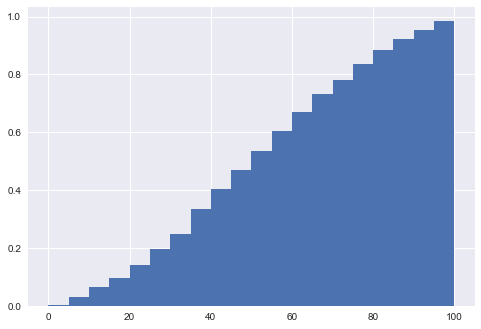

0.96805932162481501

In [33]:
bin_accuracy_plot(20,[pred[1] for pred in lda_test_preds],y_test)

In [34]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

qda_train_preds = qda.predict_proba(X_train)
qda_test_preds = qda.predict_proba(X_test)

//anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


[0.18747745426436485, 0.4183538441180363, 0.46037006351836507, 0.4990904956798545, 0.51732256979482, 0.543660673121254, 0.5494123658661216, 0.5527016082378804, 0.5706676576241794, 0.5926345609065156, 0.5892957746478873, 0.6106099984711818, 0.619896683886019, 0.6048034934497817, 0.6285572468563865, 0.6343552750225429, 0.6328535842789925, 0.6475373300646312, 0.6724651162790698, 0.7935897215685601]


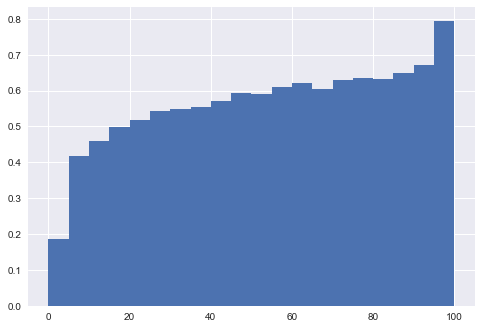

0.48198128870807566

In [35]:
bin_accuracy_plot(20,[pred[1] for pred in qda_test_preds],y_test)

In [39]:
Ks = [x for x in range(5,105,5)]
cross_val_scores = []
for k in Ks:
    knn = KNeighborsClassifier(n_neighbors = k)
    cv_scores = []
    for train_index, val_index in kf.split(X_train):
        knn.fit(X_train, y_train)
        preds = knn.predict_proba(X_train[val_index])
        acc = bin_accuracy(20, [pred[1] for pred in preds], y_train[val_index])
        cv_scores.append(acc)
    cv_score = cross_val_score(knn, X_train, y_train, cv = 5)
    cross_val_scores.append((np.mean(cv_scores), np.mean(cv_score), k))
# cross_val_scores


In [37]:
knn = KNeighborsClassifier(n_neighbors = k)
knn.fit(X_train, y_train)
knn_test_preds = knn.predict_proba(X_test)

[0.0, 0.003425724073497353, 0.010376398779247202, 0.01808895509682911, 0.04454303460514641, 0.06594578129759367, 0.12211651244624007, 0.19121184088806661, 0.306621825350806, 0.45164983336301423, 0.5275818779308054, 0.6379401826356502, 0.7874869655891553, 0.8876445086705202, 0.9340471092077087, 0.9614601018675721, 0.9799579764021336, 0.9936406995230525, 0.9982030548068284, 1.0]


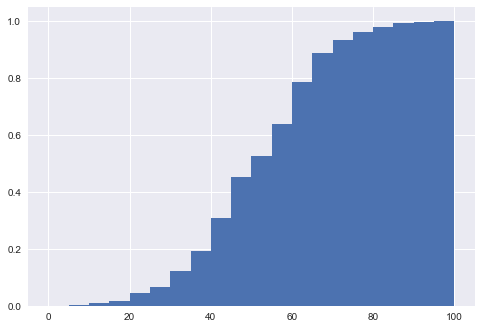

0.75494646641255214

In [38]:
bin_accuracy_plot(20,[pred[1] for pred in knn_test_preds],y_test)

In [116]:
cross_val_scores = []
trees = [2**x for x in range(7)]
for md in [1,2,5,10,None]:
    for tree in trees:
        ada=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=md),n_estimators=tree, learning_rate=.05)
        cv_scores = []
        for train_index, val_index in kf.split(X_train):
            ada.fit(X_train[train_index],y_train[train_index])
            preds = rf.predict_proba(X_train[val_index])
            acc = bin_accuracy(20, [pred[1] for pred in preds], y_train[val_index])
            cv_scores.append(acc)
        cv_score = cross_val_score(ada, X_train, y_train, cv = 5)
        cross_val_scores.append((np.mean(cv_scores), np.mean(cv_score), tree, md))
# cross_val_scores

In [114]:
cross_val_scores

[(0.99502557239425382, 0.73593364110666948, 1, 1),
 (0.99502557239425382, 0.73593364110666948, 2, 1),
 (0.99502557239425382, 0.73593364110666948, 4, 1),
 (0.99502557239425382, 0.73593364110666948, 8, 1),
 (0.99502557239425382, 0.73593364110666948, 16, 1),
 (0.99502557239425382, 0.73593364110666948, 32, 1),
 (0.99502557239425382, 0.73593364110666948, 64, 1),
 (0.99502557239425382, 0.73593364110666948, 1, 2),
 (0.99502557239425382, 0.73593364110666948, 2, 2),
 (0.99502557239425382, 0.73593364110666948, 4, 2),
 (0.99502557239425382, 0.73593364110666948, 8, 2)]

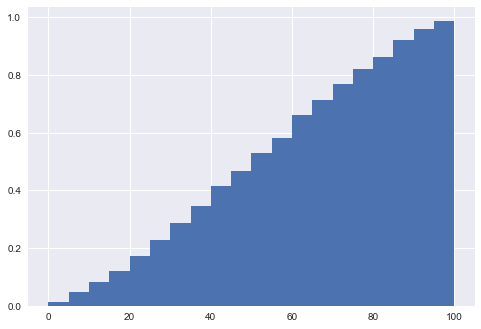

0.98522099659212115

In [115]:
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),n_estimators=10, learning_rate=.05)
ada.fit(X_train,y_train)
ada_test_preds = ada.predict_proba(X_test)
bin_accuracy_plot(20,[pred[1] for pred in ada_test_preds],y_test)

In [40]:
logit_all_preds = logit.predict_proba(X_all)
print(pd.DataFrame(logit_all_preds).describe())
plays_all['logitWP'] = [pred[1] for pred in logit_all_preds]
plays.head()

                  0             1
count  1.215489e+06  1.215489e+06
mean   4.898026e-01  5.101974e-01
std    2.953227e-01  2.953227e-01
min    8.408029e-09  8.439937e-09
25%    2.453869e-01  2.744164e-01
50%    4.880871e-01  5.119129e-01
75%    7.255836e-01  7.546131e-01
max    1.000000e+00  1.000000e+00


,gameID,date,stadium,attendance,inning,starting_pitcher,is_starting_pitcher,is_away,batting_position,score,num_outs,runners_on_base,pitch_details,run_out_result,team_at_bat,batter,pitcher,WEC%,wWE%,play_description,team_won,is_single,is_double,is_triple,is_homerun,is_strikeout,is_groundout,is_walk,is_steal,runner_on_first,runner_on_second,runner_on_third,runs_in_atbat,outs_in_atbat,batting_team_runs,fielding_team_runs,pitch_count,ball_count,strike_count,home_team_won
0,1,2006-09-08,Angel Stadium of Anaheim,"42,259",1,Joe Saunders,1,1,1,0-0,0,---,"5,(1-2) CFBFX",NaN,TOR,Reed Johnson,Joe Saunders,-6%,44%,Double to CF (Fly Ball to Deep CF),0,False,True,False,False,False,False,False,False,0,0,0,0,0,0,0,5,1,2,1
1,1,2006-09-08,Angel Stadium of Anaheim,"42,259",1,Joe Saunders,1,1,2,0-0,0,-2-,"6,(3-2) FBFBBX",O,TOR,Aaron Hill,Joe Saunders,4%,48%,Lineout: 3B,0,False,False,False,False,False,False,False,False,0,1,0,0,1,0,0,6,3,2,1
2,1,2006-09-08,Angel Stadium of Anaheim,"42,259",1,Joe Saunders,1,1,3,0-0,1,-2-,"2,(1-0) *BX",RO,TOR,Vernon Wells,Joe Saunders,-4%,44%,Single to RF (Line Drive); Johnson Scores; out...,0,True,False,False,False,False,False,False,False,0,1,0,1,1,0,0,2,1,0,1
3,1,2006-09-08,Angel Stadium of Anaheim,"42,259",1,Joe Saunders,1,1,4,1-0,2,---,"2,(0-1) CX",O,TOR,Troy Glaus,Joe Saunders,1%,45%,Lineout: 3B-1B,0,False,False,False,False,False,False,False,False,0,0,0,0,1,1,0,2,0,1,1
4,1,2006-09-08,Angel Stadium of Anaheim,"42,259",1,A.J. Burnett,1,0,1,0-1,0,---,"4,(1-2) BCCX",NaN,LAA,Maicer Izturis,A.J. Burnett,4%,49%,Single to 1B (Ground Ball),1,True,False,False,False,False,False,False,False,0,0,0,0,0,0,1,4,1,2,1


In [41]:
wPC = [plays_all['logitWP'][i]-plays_all['logitWP'][i-1] if plays_all['is_away'][i] == plays_all['is_away'][i-1] else plays_all['logitWP'][i]-(1-plays_all['logitWP'][i-1]) for i in range(1,len(plays_all['logitWP']),1)]
wPC = [plays_all['logitWP'][i]-.50 if plays_all['gameID'][i] != plays_all['gameID'][i-1] else wPC[i-1] for i in range(1,len(wPC)+1,1)]

In [42]:
wPC = [plays_all['logitWP'][0]-.50] + wPC
print(len(wPC))
print(len(plays_all['logitWP']))

1215489
1215489


In [43]:
plays_all['wPC'] = wPC
plays_all

,gameID,date,attendance,inning,is_starting_pitcher,is_away,batting_position,num_outs,team_at_bat,batter,pitcher,WEC%,wWE%,team_won,is_single,is_double,is_triple,is_homerun,is_strikeout,is_groundout,is_walk,is_steal,runner_on_first,runner_on_second,runner_on_third,runs_in_atbat,outs_in_atbat,batting_team_runs,fielding_team_runs,pitch_count,ball_count,strike_count,home_team_won,run_diff,run_scored,logitWP,wPC
0,1,2006-09-08,42259,1,1,1,1,0,TOR,Reed Johnson,Joe Saunders,-6%,44%,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,5,1,2,1,0,0,0.534008,0.034008
1,1,2006-09-08,42259,1,1,1,2,0,TOR,Aaron Hill,Joe Saunders,4%,48%,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,6,3,2,1,0,0,0.470974,-0.063034
2,1,2006-09-08,42259,1,1,1,3,1,TOR,Vernon Wells,Joe Saunders,-4%,44%,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,2,1,0,1,0,0,0.550161,0.079187
3,1,2006-09-08,42259,1,1,1,4,2,TOR,Troy Glaus,Joe Saunders,1%,45%,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,2,0,1,1,1,1,0.506042,-0.044120
4,1,2006-09-08,42259,1,1,0,1,0,LAA,Maicer Izturis,A.J. Burnett,4%,49%,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,1,2,1,-1,1,0.447065,-0.046893
5,1,2006-09-08,42259,1,1,0,2,0,LAA,Orlando Cabrera,A.J. Burnett,6%,55%,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,4,1,2,1,-1,1,0.473265,0.026200
6,1,2006-09-08,42259,1,1,0,3,0,LAA,Vladimir Guerrero,A.J. Burnett,-11%,44%,1,0,1,0,0,0,0,0,0,1,1,0,0,2,0,1,1,0,0,1,-1,1,0.394548,-0.078716
7,1,2006-09-08,42259,1,1,0,4,2,LAA,Garret Anderson,A.J. Burnett,-4%,40%,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,1,-1,1,0.318707,-0.075842
8,1,2006-09-08,42259,2,1,1,5,0,TOR,Bengie Molina,Joe Saunders,2%,42%,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,3,0,2,1,1,1,0.596783,-0.084511
9,1,2006-09-08,42259,2,1,1,6,1,TOR,Alex Rios,Joe Saunders,-4%,39%,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,5,2,2,1,1,1,0.660817,0.064035


In [44]:
plays_all['outs_left'] = [(9 - plays_all['inning'][i]) * 6 + plays_all['is_away'][i] * 3 + 3 - plays_all['num_outs'][i] if plays_all['inning'][i] <= 9 else plays_all['is_away'][i] * 3 + 3 - plays_all['num_outs'][i] for i in range(len(plays_all['is_away']))]

In [45]:
plays_all['wPCAbs'] = abs(plays_all['wPC'])
plays_all['rdAbs'] = abs(plays_all['run_diff'])

In [46]:
plays_all.head()

,gameID,date,attendance,inning,is_starting_pitcher,is_away,batting_position,num_outs,team_at_bat,batter,pitcher,WEC%,wWE%,team_won,is_single,is_double,is_triple,is_homerun,is_strikeout,is_groundout,is_walk,is_steal,runner_on_first,runner_on_second,runner_on_third,runs_in_atbat,outs_in_atbat,batting_team_runs,fielding_team_runs,pitch_count,ball_count,strike_count,home_team_won,run_diff,run_scored,logitWP,wPC,outs_left,wPCAbs,rdAbs
0,1,2006-09-08,42259,1,1,1,1,0,TOR,Reed Johnson,Joe Saunders,-6%,44%,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,5,1,2,1,0,0,0.534008,0.034008,54,0.034008,0
1,1,2006-09-08,42259,1,1,1,2,0,TOR,Aaron Hill,Joe Saunders,4%,48%,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,6,3,2,1,0,0,0.470974,-0.063034,54,0.063034,0
2,1,2006-09-08,42259,1,1,1,3,1,TOR,Vernon Wells,Joe Saunders,-4%,44%,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,2,1,0,1,0,0,0.550161,0.079187,53,0.079187,0
3,1,2006-09-08,42259,1,1,1,4,2,TOR,Troy Glaus,Joe Saunders,1%,45%,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,2,0,1,1,1,1,0.506042,-0.044120,52,0.044120,1
4,1,2006-09-08,42259,1,1,0,1,0,LAA,Maicer Izturis,A.J. Burnett,4%,49%,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,1,2,1,-1,1,0.447065,-0.046893,51,0.046893,1


In [47]:
lev_Train = plays_all[["wPCAbs",'outs_left','rdAbs']][msk]
lev_Test = plays_all[["wPCAbs",'outs_left','rdAbs']][~msk]
lev_Train['runsXouts'] = lev_Train['rdAbs'] / lev_Train['outs_left']
lev_Test['runsXouts'] = lev_Test['rdAbs'] / lev_Test['outs_left']
lev_Train['inv_rd'] = 1 / (lev_Train['rdAbs'] + 1)
lev_Test['inv_rd'] = 1 / (lev_Test['rdAbs'] + 1)
lev_Train['inv_outs'] = 1 / (lev_Train['outs_left'] + 1)
lev_Test['inv_outs'] = 1 / (lev_Test['outs_left'] + 1)

In [48]:
linLevReg = OLS(100*lev_Train["wPCAbs"], lev_Train[['outs_left','rdAbs','runsXouts','inv_rd', 'inv_outs']],interaction = True)
results = linLevReg.fit()
print(metrics.r2_score(100*lev_Test["wPCAbs"],results.predict(lev_Test[['outs_left','rdAbs','runsXouts','inv_rd', 'inv_outs']])))
results.summary()

0.169498718114


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 wPCAbs   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                 2.596e+05
Date:                Thu, 07 Dec 2017   Prob (F-statistic):               0.00
Time:                        21:25:41   Log-Likelihood:            -2.4322e+06
No. Observations:              911767   AIC:                         4.864e+06
Df Residuals:                  911762   BIC:                         4.864e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
outs_left      0.0536      0.000    186.724      0.000       0.053       0.054
rdAbs         -0.1357      0.002    -70.086      0.000      -0.140      -0.132
runsXouts     -0.7073      0.010    -70.221      0.000      -0.727      -0.688
inv_rd         3.8046      0.016    243.468      0.000       3.774       3.835
inv_outs      11.2782      0.071    159.857      0.000      11.140      11.416
==============================================================================
Omnibus:                   685202.968   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         17270995.201
Skew:                           3.415   Prob(JB):                         0.00
Kurtosis:                      23.198   Cond. No.                         622.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
plays_all['LevDif']=[10 if plays_all['run_diff'][i]>10.1 else plays_all['run_diff'][i]for i in range(len(plays_all['run_diff']))]
plays_all['LevDif']=[-10 if plays_all['run_diff'][i]<-10.1 else plays_all['LevDif'][i]for i in range(len(plays_all['run_diff']))]

In [ ]:
# this takes a long time - dont run again, info is already in a csv we saved

# levind={}
# for outs in range(1,55,1):
#     for runs in range(-10,11,1):
#         relprob=[plays_all['wPCAbs'][i] for i in range(len(plays_all['LevDif'])) if (plays_all['LevDif'][i]==runs and plays_all['outs_left'][i]==outs)]
#         stateavg=np.average(relprob)
#         levind[(outs,runs)]=stateavg

In [50]:
levinds = pd.read_csv("Leverage Index.csv")
levinds.columns = ["Outs, Runs", "LevInd"]
levinds["Outs, Runs"][0]
levinds["Outs"] = [int(sit.split('(')[1].split(',')[0]) if isinstance(sit,str) else None for sit in levinds['Outs, Runs']]
levinds["Runs"] = [int(sit.split('(')[1].split(',')[1].split(')')[0]) if isinstance(sit,str) else None for sit in levinds['Outs, Runs']]
finallevdict = {}
for i in range(len(levinds)):
    if not math.isnan(levinds["LevInd"][i]):
        finallevdict[(levinds["Outs"][i], levinds["Runs"][i])] = levinds["LevInd"][i]
    else:
        finallevdict[(levinds["Outs"][i], levinds["Runs"][i])] = 0
plays_all["LevInd"] = [finallevdict[(plays_all["outs_left"][i], plays_all["LevDif"][i])] for i in range(len(plays_all["LevDif"]))]

In [51]:
finallevdict

{(7, 3): 0.019737228041987881,
 (17, -1): 0.049806286517710657,
 (47, 8): 0.0010686413839363577,
 (48, 5): 0.0076008076771594043,
 (42, 10): 0.00030796733681658366,
 (16, 9): 0.00059829548727201992,
 (24, 5): 0.0070411754095054862,
 (31, -7): 0.003067558670082988,
 (19, 4): 0.011300752736717462,
 (23, -2): 0.038694023176726051,
 (39, 7): 0.0014299664191385921,
 (42, -8): 0.0016438965763707436,
 (18, -3): 0.026026471790747949,
 (44, 4): 0.009799025995502423,
 (20, 6): 0.0024970716234241071,
 (17, -6): 0.0037769796007552548,
 (45, 9): 0.0005219660246430502,
 (8, 5): 0.0050312862136949145,
 (32, 2): 0.02812716920527077,
 (53, -7): 0,
 (9, 0): 0.057288634919536577,
 (33, 3): 0.01492043290721316,
 (39, -8): 0.001801694723643025,
 (46, -2): 0.030497406215075119,
 (36, 8): 0.0011376519648431446,
 (10, 7): 0.0022882455047615142,
 (29, -6): 0.0034128781837215942,
 (21, -5): 0.01270398733707657,
 (25, 0): 0.05749101059122956,
 (33, 1): 0.041184294641739949,
 (22, -5): 0.0065504235148218575,
 (14

In [52]:
plays_all["LevIndXwPC"] = plays_all["LevInd"] * plays_all["wPC"]

In [53]:
plays_all.head()

,gameID,date,attendance,inning,is_starting_pitcher,is_away,batting_position,num_outs,team_at_bat,batter,pitcher,WEC%,wWE%,team_won,is_single,is_double,is_triple,is_homerun,is_strikeout,is_groundout,is_walk,is_steal,runner_on_first,runner_on_second,runner_on_third,runs_in_atbat,outs_in_atbat,batting_team_runs,fielding_team_runs,pitch_count,ball_count,strike_count,home_team_won,run_diff,run_scored,logitWP,wPC,outs_left,wPCAbs,rdAbs,LevDif,LevInd,LevIndXwPC
0,1,2006-09-08,42259,1,1,1,1,0,TOR,Reed Johnson,Joe Saunders,-6%,44%,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,5,1,2,1,0,0,0.534008,0.034008,54,0.034008,0,0,0.055366,0.001883
1,1,2006-09-08,42259,1,1,1,2,0,TOR,Aaron Hill,Joe Saunders,4%,48%,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,6,3,2,1,0,0,0.470974,-0.063034,54,0.063034,0,0,0.055366,-0.003490
2,1,2006-09-08,42259,1,1,1,3,1,TOR,Vernon Wells,Joe Saunders,-4%,44%,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,2,1,0,1,0,0,0.550161,0.079187,53,0.079187,0,0,0.056745,0.004493
3,1,2006-09-08,42259,1,1,1,4,2,TOR,Troy Glaus,Joe Saunders,1%,45%,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,2,0,1,1,1,1,0.506042,-0.044120,52,0.044120,1,1,0.058132,-0.002565
4,1,2006-09-08,42259,1,1,0,1,0,LAA,Maicer Izturis,A.J. Burnett,4%,49%,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,1,2,1,-1,1,0.447065,-0.046893,51,0.046893,1,-1,0.058995,-0.002766


In [54]:
batter_clutch_sum = pd.DataFrame((plays_all.groupby('batter')['LevIndXwPC'].sum()))
batter_clutch_sum["ABs"] = (plays_all.groupby('batter')['LevIndXwPC'].count())
batter_clutch_mean = pd.DataFrame((plays_all.groupby('batter')['LevIndXwPC'].mean()))
batter_clutch_mean["ABs"] = (plays_all.groupby('batter')['LevIndXwPC'].count())
pitcher_clutch_mean = pd.DataFrame((plays_all.groupby('pitcher')['LevIndXwPC'].mean()))
pitcher_clutch_mean["PitchABs"] = (plays_all.groupby('pitcher')['LevIndXwPC'].count())
pitcher_clutch_sum = pd.DataFrame((plays_all.groupby('pitcher')['LevIndXwPC'].sum()))
pitcher_clutch_sum["PitchABs"] = (plays_all.groupby('pitcher')['LevIndXwPC'].count())
pitcher_clutch_sum.sort_values("LevIndXwPC")

,LevIndXwPC,PitchABs
pitcher,,
Clayton Kershaw,-4.203734,4187
Zack Greinke,-3.470004,4757
Madison Bumgarner,-3.369916,4239
Max Scherzer,-3.041837,4595
Jon Lester,-3.034650,5195
John Lackey,-2.950085,5500
Adam Wainwright,-2.845882,4713
Cole Hamels,-2.802086,5375
Justin Verlander,-2.707712,5529


In [57]:
batter_clutch_sum.sort_values("LevIndXwPC", ascending=False)

,LevIndXwPC,ABs
batter,,
Paul Goldschmidt,0.502293,3411
Giancarlo Stanton,0.454635,2737
Mike Trout,0.451892,3398
Joey Votto,0.398170,3381
Miguel Cabrera,0.359185,4106
David Ortiz,0.342667,3568
Magglio Ordonez,0.221910,956
Barry Bonds,0.169637,554
Chipper Jones,0.165632,755


In [58]:
pitcher_clutch_mean.sort_values("LevIndXwPC")[pitcher_clutch_mean["PitchABs"] > 500]

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,LevIndXwPC,PitchABs
pitcher,,
Clayton Kershaw,-0.001004,4187
Kenley Jansen,-0.000815,1438
Madison Bumgarner,-0.000795,4239
Zack Greinke,-0.000729,4757
Orlando Hernandez,-0.000728,741
Koji Uehara,-0.000714,1111
Parker Bridwell,-0.000700,518
Craig Kimbrel,-0.000699,1311
Hyun-Jin Ryu,-0.000694,2064


In [60]:
batter_clutch_mean.sort_values("LevIndXwPC", ascending=False)[batter_clutch_mean["ABs"] > 500]

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,LevIndXwPC,ABs
batter,,
Barry Bonds,0.000306,554
Jack Cust,0.000265,603
Magglio Ordonez,0.000232,956
Chipper Jones,0.000219,755
Pat Burrell,0.000178,804
Jim Thome,0.000173,727
Giancarlo Stanton,0.000166,2737
Paul Goldschmidt,0.000147,3411
Mike Trout,0.000133,3398


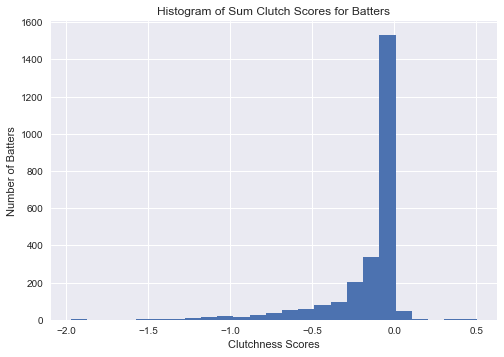

In [81]:
plt.hist(batter_clutch_sum['LevIndXwPC'], bins=25)
plt.title('Histogram of Sum Clutch Scores for Batters')
plt.xlabel('Clutchness Scores')
plt.ylabel('Number of Batters')
plt.show()

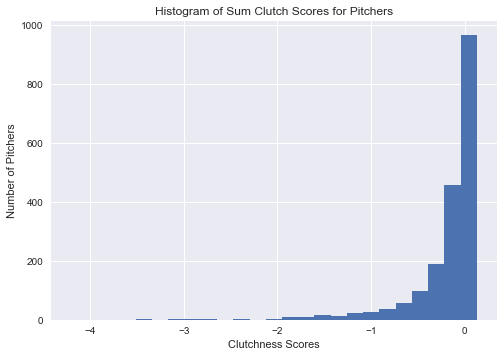

In [82]:
plt.hist(pitcher_clutch_sum['LevIndXwPC'], bins=25)
plt.title('Histogram of Sum Clutch Scores for Pitchers')
plt.xlabel('Clutchness Scores')
plt.ylabel('Number of Pitchers')
plt.show()

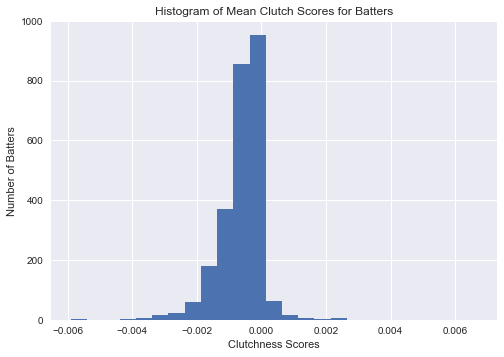

In [83]:
plt.hist(batter_clutch_mean['LevIndXwPC'], bins=25)
plt.title('Histogram of Mean Clutch Scores for Batters')
plt.xlabel('Clutchness Scores')
plt.ylabel('Number of Batters')
plt.show()

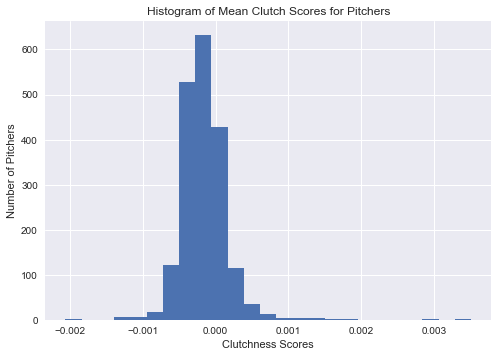

In [84]:
plt.hist(pitcher_clutch_mean['LevIndXwPC'], bins=25)
plt.title('Histogram of Mean Clutch Scores for Pitchers')
plt.xlabel('Clutchness Scores')
plt.ylabel('Number of Pitchers')
plt.show()

In [88]:
batter_clutch_mean = batter_clutch_mean.sort_values("LevIndXwPC", ascending=False)[batter_clutch_mean["ABs"] > 500]
pitcher_clutch_mean = pitcher_clutch_mean.sort_values("LevIndXwPC")[pitcher_clutch_mean["PitchABs"] > 500]
batter_clutch_sum = batter_clutch_sum.sort_values("LevIndXwPC", ascending=False)
pitcher_clutch_sum = pitcher_clutch_sum.sort_values("LevIndXwPC", ascending=False)

best_worst_batters_mean = pd.concat([batter_clutch_mean['LevIndXwPC'][:5], batter_clutch_mean['LevIndXwPC'][-5:]])
best_worst_batters_sum = pd.concat([batter_clutch_sum['LevIndXwPC'][:5], batter_clutch_sum['LevIndXwPC'][-5:]])
best_worst_pitchers_mean = pd.concat([pitcher_clutch_mean['LevIndXwPC'][:5], pitcher_clutch_mean['LevIndXwPC'][-5:]])
best_worst_pitchers_sum = pd.concat([pitcher_clutch_sum['LevIndXwPC'][:5], pitcher_clutch_sum['LevIndXwPC'][-5:]])

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [99]:
import sys  

reload(sys)  
sys.setdefaultencoding('utf8')

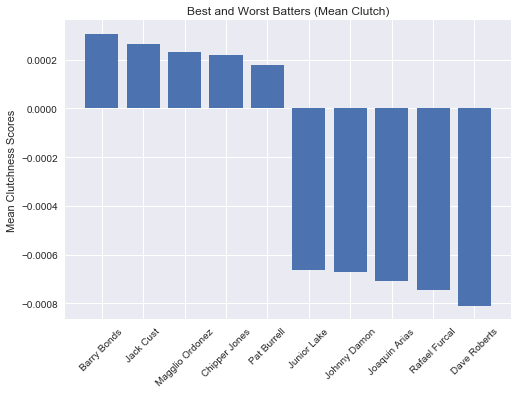

In [109]:
fig, ax = plt.subplots()
ax.bar(range(len(best_worst_batters_mean)), best_worst_batters_mean, tick_label=list(best_worst_batters_mean.index))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
plt.title('Best and Worst Batters (Mean Clutch)')
plt.ylabel('Mean Clutchness Scores')
plt.show()

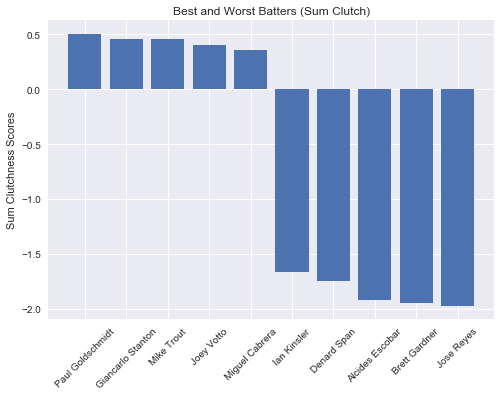

In [110]:
fig, ax = plt.subplots()
ax.bar(range(len(best_worst_batters_sum)), best_worst_batters_sum, tick_label=list(best_worst_batters_sum.index))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
plt.title('Best and Worst Batters (Sum Clutch)')
plt.ylabel('Sum Clutchness Scores')
plt.show()

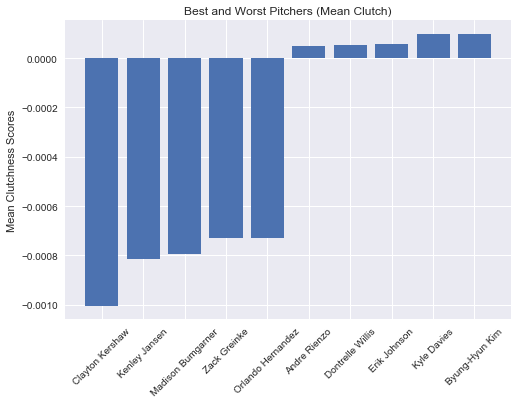

In [111]:
fig, ax = plt.subplots()
ax.bar(range(len(best_worst_pitchers_mean)), best_worst_pitchers_mean, tick_label=list(best_worst_pitchers_mean.index))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
plt.title('Best and Worst Pitchers (Mean Clutch)')
plt.ylabel('Mean Clutchness Scores')
plt.show()

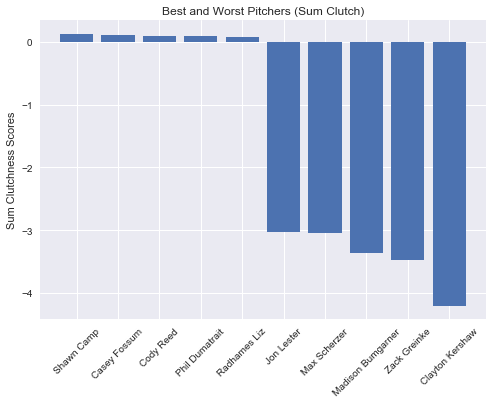

In [112]:
fig, ax = plt.subplots()
ax.bar(range(len(best_worst_pitchers_sum)), best_worst_pitchers_sum, tick_label=list(best_worst_pitchers_sum.index))
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
plt.title('Best and Worst Pitchers (Sum Clutch)')
plt.ylabel('Sum Clutchness Scores')
plt.show()